In [1]:
# General imports
import numpy as np
np.random.seed(42)
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import os
import yaml
import importlib.util
from resum.multi_fidelity_gaussian_process import MultiFidelityVisualizer
from resum.multi_fidelity_gaussian_process import MFGPModel

 /home/bliu4/resum-coherent2/resum/multi_fidelity_gaussian_process/multi_fidelity_visualizer.py:168: SyntaxWarning:invalid escape sequence '\p'
 /home/bliu4/resum-coherent2/resum/multi_fidelity_gaussian_process/multi_fidelity_visualizer.py:168: SyntaxWarning:invalid escape sequence '\p'
 /home/bliu4/resum-coherent2/resum/multi_fidelity_gaussian_process/multi_fidelity_visualizer.py:168: SyntaxWarning:invalid escape sequence '\p'
 /home/bliu4/resum-coherent2/resum/multi_fidelity_gaussian_process/multi_fidelity_visualizer.py:216: SyntaxWarning:invalid escape sequence '\p'
 /home/bliu4/resum-coherent2/resum/multi_fidelity_gaussian_process/multi_fidelity_visualizer.py:277: SyntaxWarning:invalid escape sequence '\p'
 /home/bliu4/resum-coherent2/resum/multi_fidelity_gaussian_process/multi_fidelity_visualizer.py:278: SyntaxWarning:invalid escape sequence '\p'
 /home/bliu4/resum-coherent2/resum/multi_fidelity_gaussian_process/multi_fidelity_visualizer.py:279: SyntaxWarning:invalid escape sequen

In [2]:
path_to_settings = "../coherent"
with open(f"{path_to_settings}/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_mfgp = config_file["path_settings"]["path_out_mfgp"]
file_in=f'{path_out_cnp}/cnp_{version}_output.csv'


In [3]:
if not os.path.exists(path_out_mfgp):
   os.makedirs(path_out_mfgp)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

# Set parameter boundaries
xmin = config_file["simulation_settings"]["theta_min"]
xmax = config_file["simulation_settings"]["theta_max"]
x_fixed = config_file["simulation_settings"]["theta_fixed"]
parameters={}
for i,x in enumerate(x_labels):
   parameters[x]=[xmin[i],xmax[i]]

# Assign costs
low_fidelity_cost = config_file["simulation_settings"]["lf_cost"]
high_fidelity_cost = config_file["simulation_settings"]["lf_cost"]

In [4]:
data=pd.read_csv(file_in)

In [5]:
LF_cnp_noise=np.mean(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
HF_cnp_noise=np.mean(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
LF_sim_noise=np.std(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_sim].to_numpy())
HF_sim_noise=np.std(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy())

x_train_l, x_train_h, y_train_l, y_train_h = ([],[],[],[])
row_h=data.index[data['fidelity'] == 1].tolist()
row_l=data.index[data['fidelity'] == 0].tolist()

x_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy().tolist()

x_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][ y_label_cnp].to_numpy().tolist()

x_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][ y_label_sim].to_numpy().tolist()

x_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][ y_label_cnp].to_numpy().tolist()

In [6]:
trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "mf": [x_train_hf_cnp,y_train_hf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
noise = {"lf": LF_cnp_noise, "mf": 0.0, "hf": 0.0}

In [7]:
# Path to the inequalities.py file
file_path = f"{path_to_settings}/inequalities.py"

if os.path.exists(file_path):
    spec = importlib.util.spec_from_file_location("inequalities", file_path)
    inequalities_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(inequalities_module)
    InequalityConstraints = inequalities_module.InequalityConstraints
    inequalities = InequalityConstraints()
    print("InequalityConstraints loaded successfully.")
else:
    inequalities = None

InequalityConstraints loaded successfully.


In [8]:
# Run data analysis to diagnose the multi-fidelity issues
mf_model.analyze_training_data()

NameError: name 'mf_model' is not defined

In [9]:
# Test different approaches systematically

# APPROACH 1: Try the fixed original method with bounds
print("=== TESTING APPROACH 1: Fixed Linear Multi-Fidelity ===")
try:
    mf_model_v1 = MFGPModel(trainings_data, noise, inequality_constraints=inequalities)
    mf_model_v1.build_model(10)
    print("✓ Approach 1 succeeded!")
    
    # Check if parameters look reasonable
    try:
        params = str(mf_model_v1.model.gpy_model)
        if "nan" in params.lower() or "inf" in params.lower():
            print("⚠️  Warning: NaN or Inf values detected in parameters")
        else:
            print("✓ Parameters look reasonable")
    except:
        pass
        
except Exception as e:
    print(f"✗ Approach 1 failed: {e}")
    mf_model_v1 = None

print("\n" + "="*60)

# # APPROACH 2: Try alternative method with Matern kernels
# print("=== TESTING APPROACH 2: Alternative Matern Kernels ===")
# try:
#     mf_model_v2 = MFGPModel(trainings_data, noise, inequality_constraints=inequalities)
#     mf_model_v2.build_model_alternative(10, use_independent_kernels=False)
#     print("✓ Approach 2 succeeded!")
# except Exception as e:
#     print(f"✗ Approach 2 failed: {e}")
#     mf_model_v2 = None

# print("\n" + "="*60)

# # APPROACH 3: Try independent kernels (fallback option)
# print("=== TESTING APPROACH 3: Independent Models per Fidelity ===")
# try:
#     mf_model_v3 = MFGPModel(trainings_data, noise, inequality_constraints=inequalities)
#     mf_model_v3.build_model_alternative(10, use_independent_kernels=True)
#     print("✓ Approach 3 succeeded!")
# except Exception as e:
#     print(f"✗ Approach 3 failed: {e}")
#     mf_model_v3 = None

# # Choose the best working model
# print("\n" + "="*60)
# print("=== SELECTING BEST MODEL ===")

# if mf_model_v1 is not None:
#     mf_model = mf_model_v1
#     print("Using Approach 1: Fixed Linear Multi-Fidelity")
# elif mf_model_v2 is not None:
#     mf_model = mf_model_v2
#     print("Using Approach 2: Alternative Matern Kernels")
# elif mf_model_v3 is not None:
#     mf_model = mf_model_v3
#     print("Using Approach 3: Independent Models")
# else:
#     print("❌ All approaches failed! Check your data and noise setup.")
#     mf_model = None

mf_model = mf_model_v1

reconstraining parameters RBF_rho_0.lengthscale
reconstraining parameters RBF_delta_0.lengthscale
reconstraining parameters RBF_rho_0.variance
reconstraining parameters RBF_delta_0.variance
reconstraining parameters RBF_rho_1.lengthscale
reconstraining parameters RBF_delta_1.lengthscale
reconstraining parameters RBF_rho_1.variance
reconstraining parameters RBF_delta_1.variance


=== TESTING APPROACH 1: Fixed Linear Multi-Fidelity ===
Training data shapes:
  Fidelity lf: X=(60, 2), Y=(60, 1)
  Fidelity mf: X=(150, 2), Y=(150, 1)
  Fidelity hf: X=(150, 2), Y=(150, 1)
Combined X_train shape: (360, 3), Y_train shape: (360, 1)
Input dimension for kernels: 2
Auto-computed lengthscale: 30.0
  Kernel 0: lengthscale bounds [3.00, 300.00]
  Kernel 1: lengthscale bounds [3.00, 300.00]
Setting noise levels:
  Fidelity lf: original noise = 0.006637
  Fidelity lf: final noise = 0.006637
  Fidelity mf: original noise = 0.0
  Fidelity mf: final noise = 0.0001
  Fidelity hf: original noise = 0.0
  Fidelity hf: final noise = 0.0001
Starting optimization with 10 restarts...
Initial log likelihood: 1121.3682097474302
Optimization restart 1/10, f = -1166.697688975293
Optimization restart 2/10, f = -1166.6976463625692
Optimization restart 3/10, f = -1166.7457411492323
Optimization restart 4/10, f = -1166.697676591999
Optimization restart 5/10, f = -1166.6975590056718
Optimization r

In [9]:
# Quick diagnostic check for your original issue
print("=== DIAGNOSTIC: Why Red and Blue Lines Don't Overlap ===")

# Check the correlation between your fidelities
import pandas as pd

# Load your data to check correlations
data_file = f'{path_out_cnp}/cnp_{version}_output.csv'
df = pd.read_csv(data_file)

# Check correlations between fidelities
lf_data = df[df['fidelity'] == 0]['y_cnp'].values
hf_data = df[df['fidelity'] == 1]['y_cnp'].values

print(f"Low fidelity (LF) predictions: {len(lf_data)} samples")
print(f"High fidelity (HF) predictions: {len(hf_data)} samples")

if len(lf_data) > 0 and len(hf_data) > 0:
    print(f"LF range: [{lf_data.min():.4f}, {lf_data.max():.4f}]")
    print(f"HF range: [{hf_data.min():.4f}, {hf_data.max():.4f}]")
    
    # If same number of samples, check correlation
    if len(lf_data) == len(hf_data):
        correlation = np.corrcoef(lf_data, hf_data)[0,1]
        print(f"LF-HF correlation: {correlation:.3f}")
        
        if correlation < 0.5:
            print("❌ Poor correlation! Multi-fidelity approach may not be suitable.")
            print("   Consider using independent models (Approach 3)")
        else:
            print("✓ Good correlation. Multi-fidelity should work.")
    else:
        print("Cannot compute correlation - different sample sizes")

print(f"\nPossible reasons for non-overlapping lines:")
print("1. Poor fidelity correlation (< 0.5)")
print("2. Very different noise levels between fidelities") 
print("3. Numerical optimization issues (extreme parameters)")
print("4. Insufficient training data for correlation learning")
print("5. Linear assumption incorrect for your problem")


=== DIAGNOSTIC: Why Red and Blue Lines Don't Overlap ===
Low fidelity (LF) predictions: 60 samples
High fidelity (HF) predictions: 150 samples
LF range: [0.3138, 0.3411]
HF range: [0.3132, 0.3307]
Cannot compute correlation - different sample sizes

Possible reasons for non-overlapping lines:
1. Poor fidelity correlation (< 0.5)
2. Very different noise levels between fidelities
3. Numerical optimization issues (extreme parameters)
4. Insufficient training data for correlation learning
5. Linear assumption incorrect for your problem


In [10]:
mf_model.model.gpy_model

gp.,value,constraints,priors
multifidelity.RBF_rho_0.variance,0.056165189125260355,"1e-06,10.0",
multifidelity.RBF_rho_0.lengthscale,299.99973437602324,"3.0,300.0",
multifidelity.RBF_delta_0.variance,1e-06,"1e-06,10.0",
multifidelity.RBF_delta_0.lengthscale,1.597264116907752,"0.1,10.0",
multifidelity.RBF_rho_1.variance,1e-06,"1e-06,10.0",
multifidelity.RBF_rho_1.lengthscale,3.000000164427822,"3.0,300.0",
multifidelity.RBF_delta_1.variance,5.779216890499708,"1e-06,10.0",
multifidelity.RBF_delta_1.lengthscale,2.9453029919995406,"0.1,10.0",
multifidelity.scale,"(3,)",,
mixed_noise.Gaussian_noise.variance,0.006637,+ve fixed,


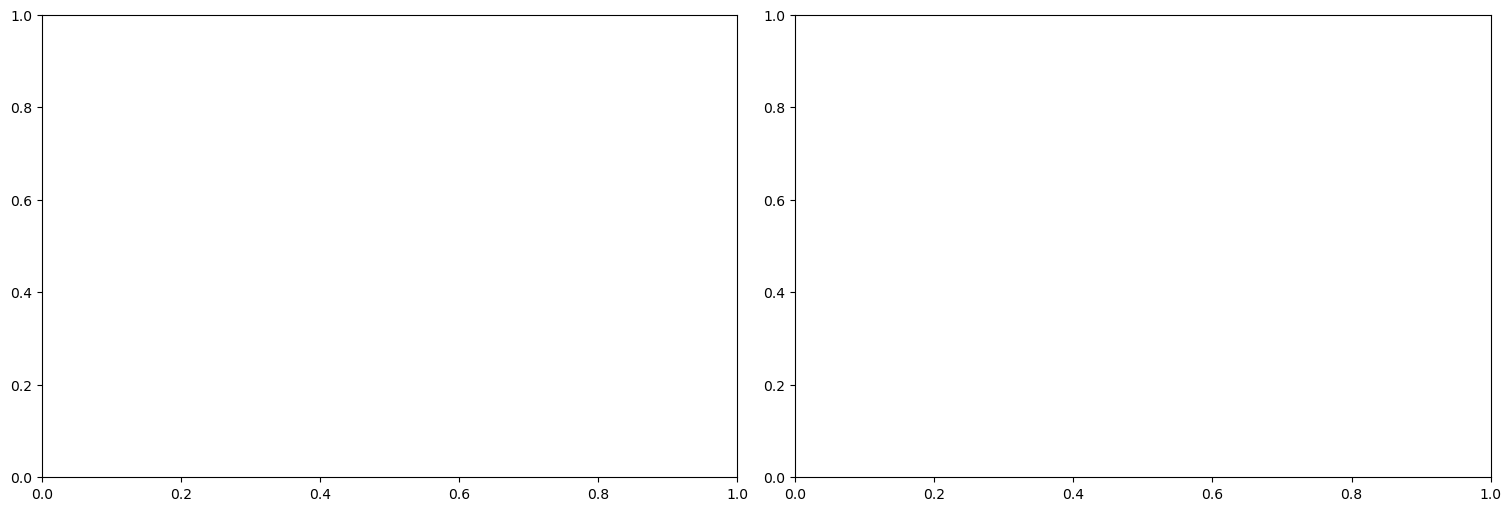

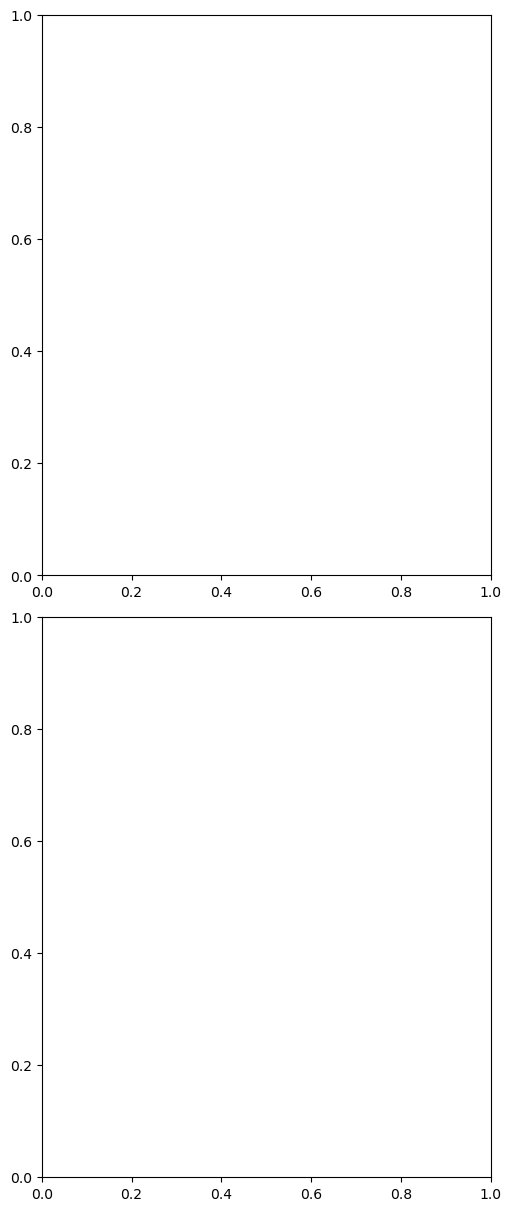

In [11]:
leg_label = []
ncol=2
nrow=int(np.ceil(len(x_labels)/ncol))
fig2,_  = plt.subplots(nrow, ncol, figsize=(15, 5), constrained_layout=True)
fig4,_  = plt.subplots(int(np.ceil(len(x_labels)/1)), 1, figsize=(5, 12), constrained_layout=True)

In [12]:
mf_vis = MultiFidelityVisualizer(mf_model,parameters,x_fixed)

Sample # 0


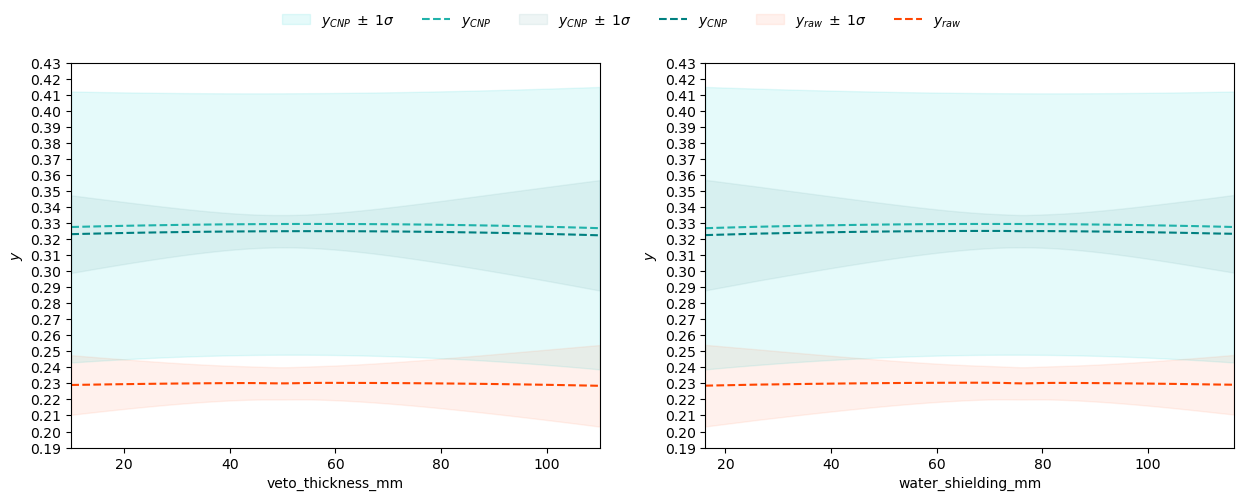

In [13]:
sample=0
active_learning = False
add_new_sample=True
mf_model.set_traings_data(trainings_data)

while ( sample <= data['iteration'].max()):
    print('Sample #', sample)

    if sample > 0:    

        x_train_hf_sim = data[(data['fidelity']==1.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_hf_sim = data[(data['fidelity']==1.) & (data['iteration']==sample)][y_label_sim].to_numpy().tolist()
        print(f"Adding {x_train_hf_sim}")   
        x_train_hf_cnp = data[(data['fidelity']==1.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_hf_cnp = data[(data['fidelity']==1.) & (data['iteration']==sample)][y_label_cnp].to_numpy().tolist()

        x_train_lf_cnp = data[(data['fidelity']==0.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_lf_cnp = data[(data['fidelity']==0.) & (data['iteration']==sample)][ y_label_cnp].to_numpy().tolist()
        trainings_data_new = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "mf": [x_train_hf_cnp,y_train_hf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
        mf_model.set_data(trainings_data_new)
        print("hi")


    # run the model drawing
    fig1, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=False)
    fig1 = mf_vis.draw_model_projections(fig1)
    fig2 = mf_vis.draw_model_projections(fig2)

    # find the next data point
    if sample == data['iteration'].max() and active_learning==True:
        x_next_sample, us_acquisition = mf_model.max_acquisition_integrated_variance_reduction(parameters)
        print(f'next suggested point to simulated is at: {x_next_sample}')
        fig4 = mf_vis.draw_acquisition_func(fig4, us_acquisition, np.array(x_next_sample))
        
    sample+=1

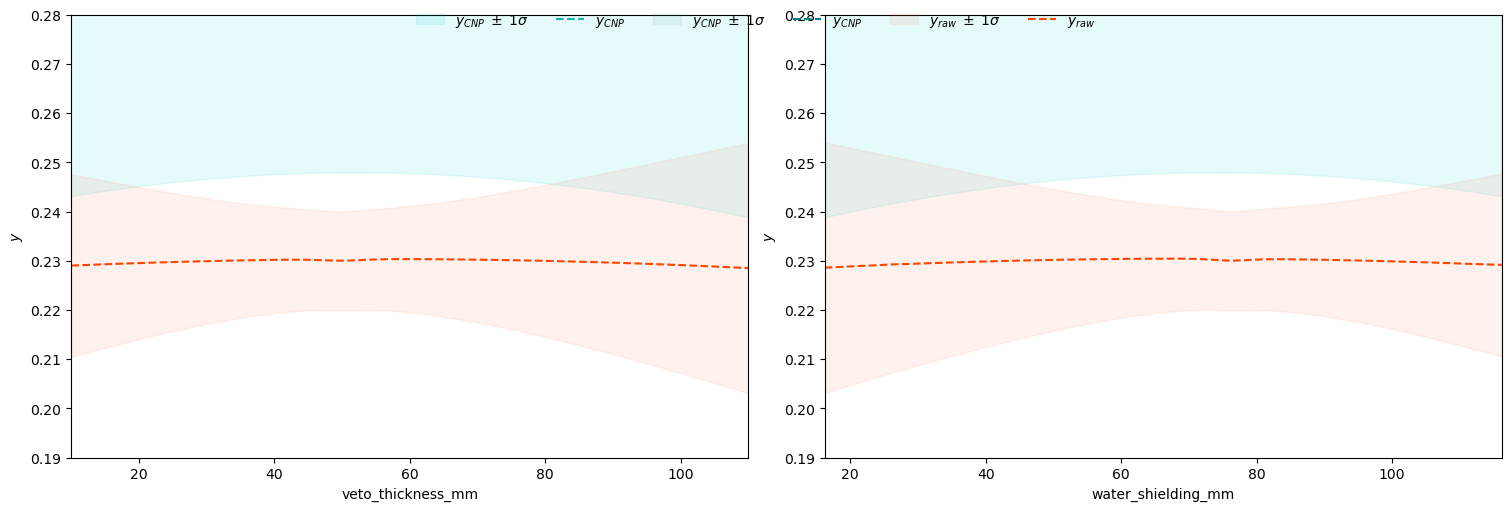

In [14]:
# Adjust tick marks on the original plots (fig1, fig2)
for _fig in [fig1, fig2]:
    for _ax in _fig.axes:
        ymin, ymax = _ax.get_ylim()
        _ax.set_yticks(np.arange(np.floor(ymin * 100) / 100, np.ceil(ymax * 100) / 100 + 0.01, 0.01))

# Create a zoom-in plot with y-axis limited to [0.19, 0.27] and ticks every 0.01
fig_zoom, _ = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
fig_zoom = mf_vis.draw_model_projections(fig_zoom)
for _ax in fig_zoom.axes:
    _ax.set_ylim(0.19, 0.27)
    _ax.set_yticks(np.arange(0.19, 0.28, 0.01))

# Save all figures
fig1.savefig(f"{path_out_mfgp}/mfgp_{version}_model_proj.png")
fig2.savefig(f"{path_out_mfgp}/mfgp_{version}_model_proj_updated.png")
fig_zoom.savefig(f"{path_out_mfgp}/mfgp_{version}_model_proj_zoomed.png")

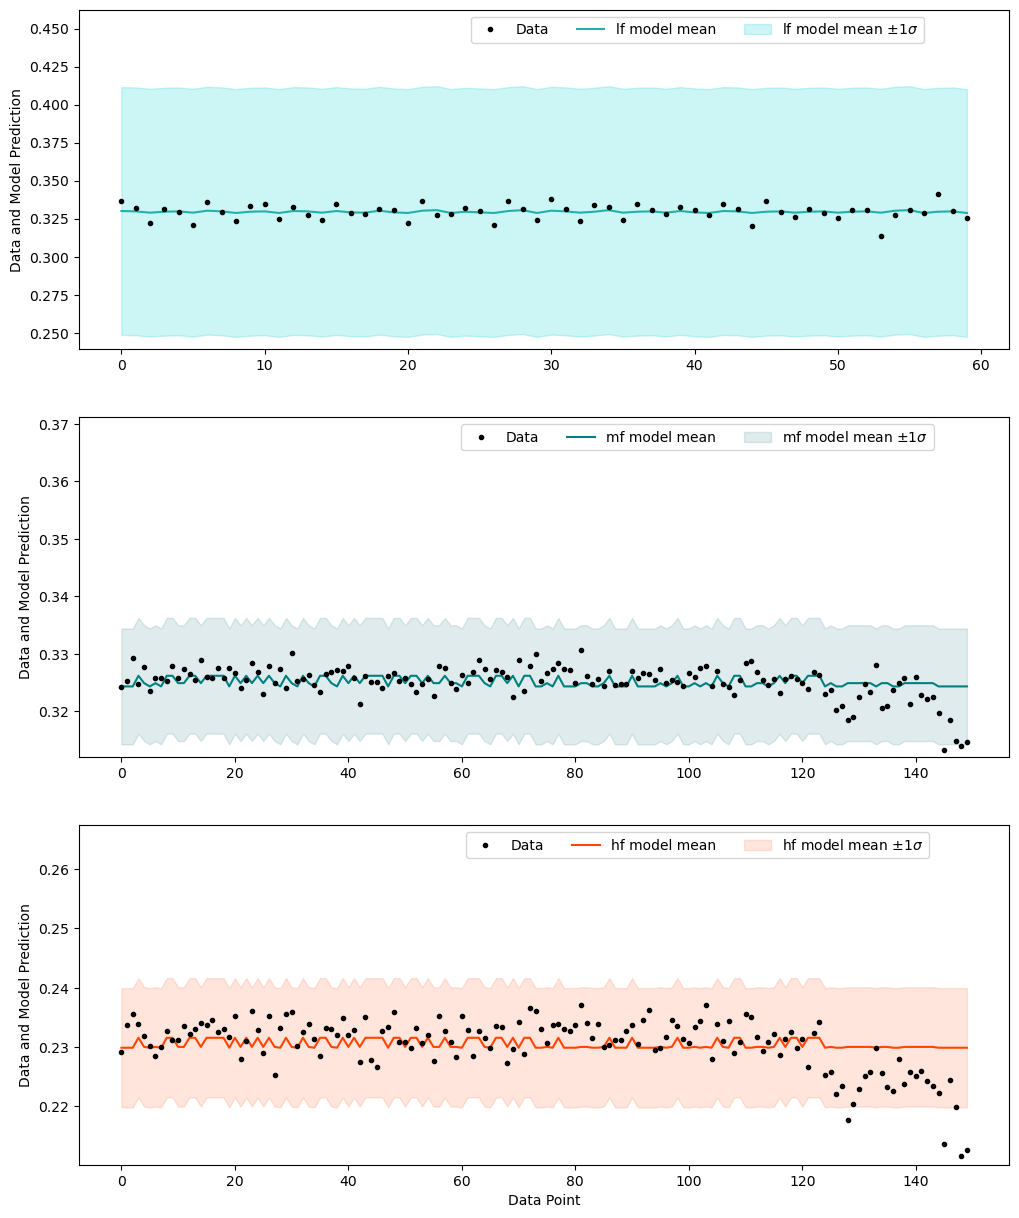

In [15]:
fig3 = mf_vis.draw_model()
fig3.savefig(f"{path_out_mfgp}/mfgp_{version}_model.png")

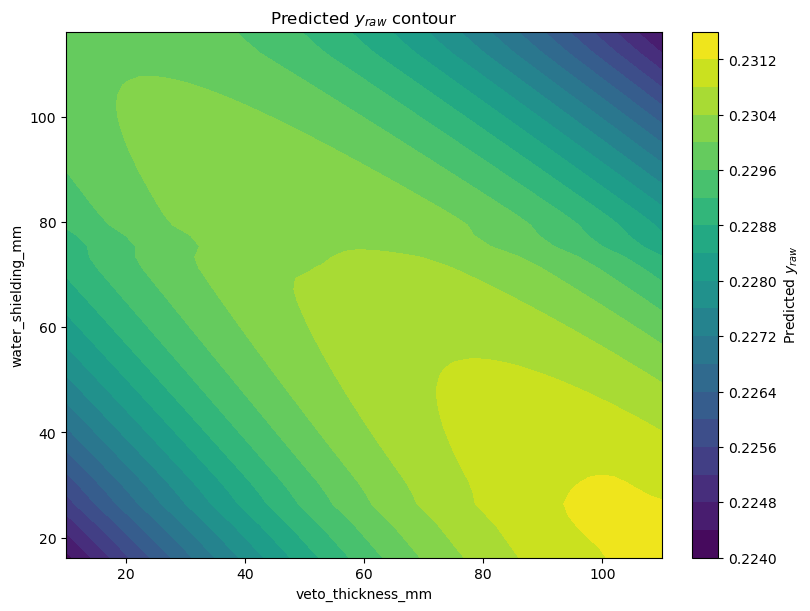

In [16]:
# ---- 2-D contour of y_raw vs veto_thickness_mm & water_shielding_mm ----
fig_cont = mf_vis.draw_yraw_contour("veto_thickness_mm",
                                    "water_shielding_mm",
                                    grid_steps=50)
fig_cont.savefig(f"{path_out_mfgp}/mfgp_{version}_yraw_contour.png")
plt.show()

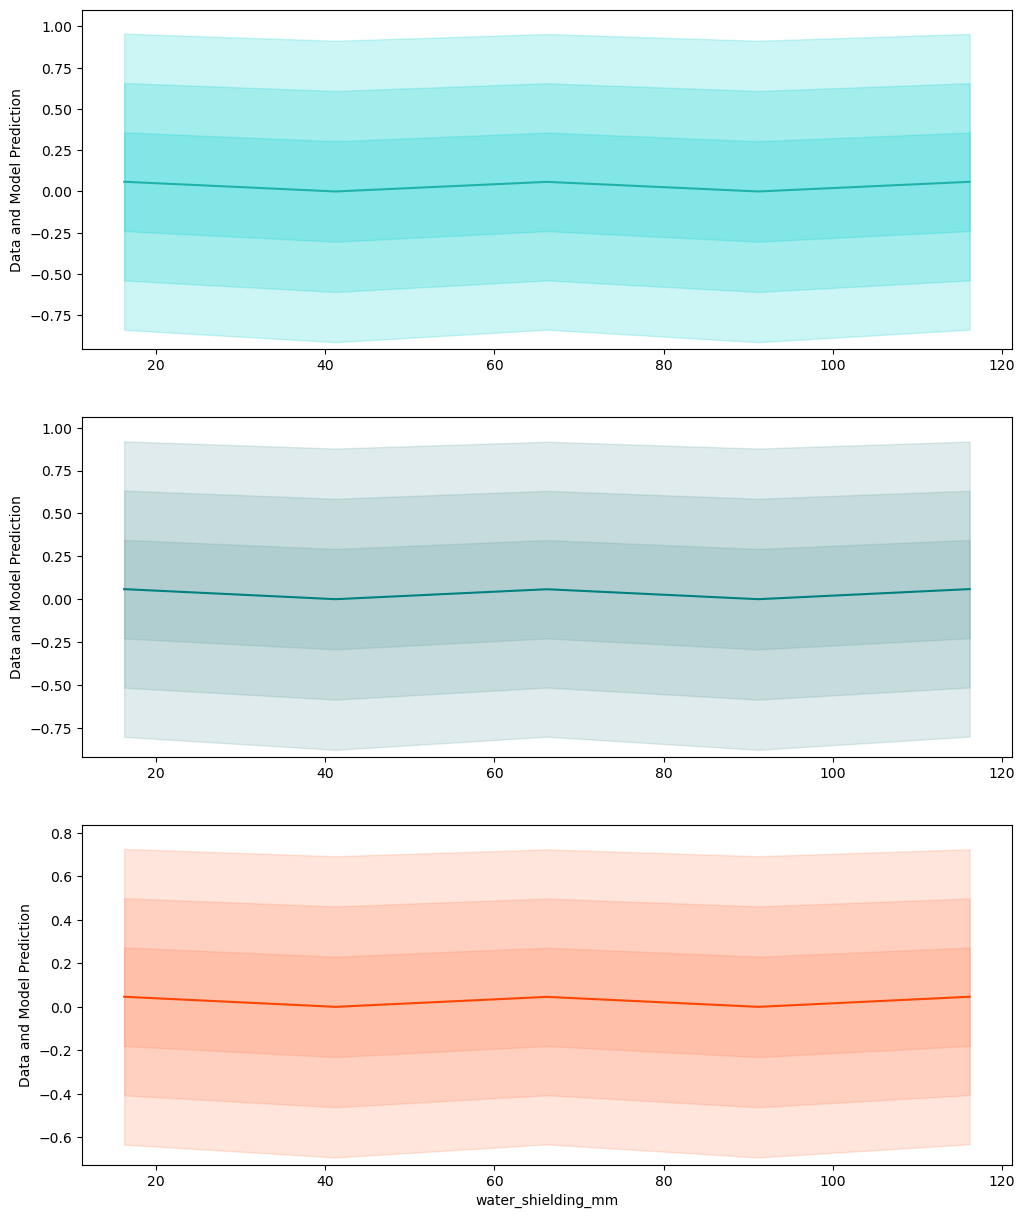

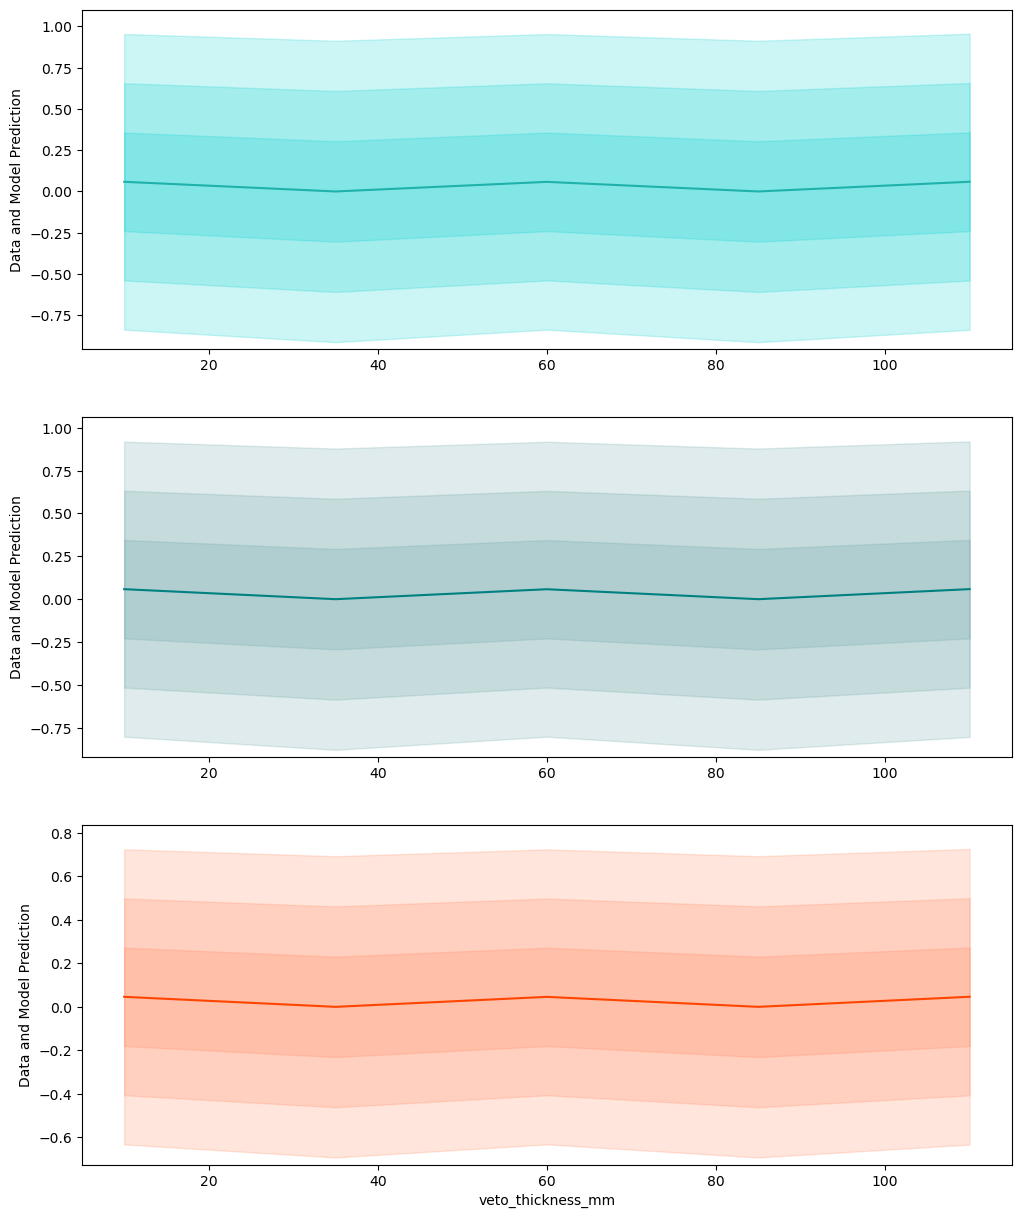

In [23]:
for x in range(len(x_labels)):
    fig5 = mf_vis.draw_model_marginalized(x,grid_steps=5)
    fig5.savefig(f"{path_out_mfgp}/mfgp_{version}_marg_{x}.png")